# Описание проекта
Цель этого проекта - анализ оттока клиентов фитнес-клуба и разработка рекомендаций по их удержанию. Факт оттока в фитнес-клубе определяется как отсутствие походов в течение последнего месяца

В рамках проекта мы попробуем спрогнозировать вероятность оттока с помощью модели логистической регрессии и алгоритма случайного леса, составим типичные портреты клиентов с помощью кластерного анализа, проанализируем основные признаки, наиболее сильно влияющие на отток клиентов.

## Загрузка библиотек и базы данных, предобработка данных

В этом разделе мы загрузим библиотеки для работы, базу данных с клиентами и их действиями, а затем проведем обзор данных

### Загрузка данных и обзор
Загрузка библиотек для работы

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans
import itertools

Загрузка датафрейма и просмотр первых 10 строчек

In [2]:
df = pd.read_csv('gym_churn.csv')
df.head(10)

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0
5,1,1,0,0,1,1,1,34,450.743960,1.0,3,2.623477,2.637007,0
6,1,1,1,1,0,6,1,32,94.266389,6.0,2,1.138941,1.277242,0
7,0,1,0,0,1,1,0,30,217.786641,1.0,0,1.213502,1.049387,1
8,1,1,1,1,1,1,1,23,45.409909,1.0,1,1.106239,1.059333,0
9,0,1,0,0,1,1,0,31,65.310836,1.0,11,1.810852,1.951368,0


Просмотр основной информации о базе данных.

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

Согласно документации и данным, датафрейм содержит следующие переменные:

- Данные клиента за предыдущий до проверки факта оттока месяц:
  - `gender` — пол (1 - женщины, 0 - мужчины);
  - `Near_Location` — проживание или работа в районе, где находится фитнес-центр;
  - `Partner` — сотрудник компании-партнёра клуба (сотрудничество с компаниями, чьи сотрудники могут получать скидки на абонемент — в таком случае фитнес-центр хранит информацию о работодателе клиента);
  - `Promo_friends` — факт первоначальной записи в рамках акции «приведи друга» (использовал промо-код от знакомого при оплате первого абонемента);
  - `Phone` — наличие контактного телефона;
  - `Age` — возраст;
  - `Lifetime` — время с момента первого обращения в фитнес-центр (в месяцах).
- Информация на основе журнала посещений, покупок и информация о текущем статусе абонемента клиента:
  - `Contract_period` — длительность текущего действующего абонемента (месяц, 6 месяцев, год);
  - `Month_to_end_contract` — срок до окончания текущего действующего абонемента (в месяцах);
  - `Group_visits` — факт посещения групповых занятий;
  - `Avg_class_frequency_total` — средняя частота посещений в неделю за все время с начала действия абонемента;
  - `Avg_class_frequency_current_month` — средняя частота посещений в неделю за предыдущий месяц;
  - `Avg_additional_charges_total` — суммарная выручка от других услуг фитнес-центра: кафе, спорттовары, косметический и массажный салон.
- `Churn` — факт оттока в текущем месяце.

Можно увидеть, что в данных нет пропущенных значений. Стоит отдельно проверить данные на наличие дубликатов, унифицировать написание названий переменных (до строчных букв), изменить тип переменной `Month_to_end_contract` на `int`, так как, как мы видим по первым 10 строчкам, все значения в этой переменной целочисленные.

### Изменение названий переменных

Меняем написание названий переменных, затем выводим их на экран

In [4]:
df.columns = df.columns.str.lower()
df.columns

Index(['gender', 'near_location', 'partner', 'promo_friends', 'phone',
       'contract_period', 'group_visits', 'age',
       'avg_additional_charges_total', 'month_to_end_contract', 'lifetime',
       'avg_class_frequency_total', 'avg_class_frequency_current_month',
       'churn'],
      dtype='object')

### Проверка дубликатов

Проверяем, есть ли в данных дубликаты. Их не оказывается

In [5]:
df.duplicated().sum()

0

### Изменение типов переменных
Перед тем, как изменить тип переменной, просматриваем все значения в переменной `month_to_end_contract`, они все действительно оказываются целочисленными. После этого меняем тип переменной и выводим все типы переменных.

In [6]:
print(df['month_to_end_contract'].value_counts())
df['month_to_end_contract'] = df['month_to_end_contract'].astype('int')
df.dtypes

1.0     2207
6.0      645
12.0     524
11.0     181
5.0      130
10.0      82
9.0       73
4.0       58
8.0       38
7.0       25
3.0       23
2.0       14
Name: month_to_end_contract, dtype: int64


gender                                 int64
near_location                          int64
partner                                int64
promo_friends                          int64
phone                                  int64
contract_period                        int64
group_visits                           int64
age                                    int64
avg_additional_charges_total         float64
month_to_end_contract                  int32
lifetime                               int64
avg_class_frequency_total            float64
avg_class_frequency_current_month    float64
churn                                  int64
dtype: object

### Вывод по разделу
В этом разделе мы загрузили библиотеки и базу данных, провели обзор данных, после которого изменили написание названий переменных и изменили тип переменной `month_to_end_contract` на целочисленный.

## Исследовательский анализ данных

В этом разделе мы проведем исследовательский анализ данных:
* Выведем описательную статистику по переменным
* Сравним средние значения в признаках между двумя группами (тех, кто ушел в отток, и тех, кто остался)
* Построим столбчатые диаграмммы и распределения признаков тех, кто ушел в отток, и тех, кто остался
* Построим матриццу корреляций и отобразим ее

### Описательная статистика по переменным

Выведем описательную статистику по переменным. Можем сделать следующие выводы:
- В базе данных примерно поровну женщин и мужчин (доля женщин равна ~51%, мужчин ~49%)
- Около 85% клиентов проживают или работают в районе, где находится фитнес центр
- Чуть меньше половины клиентов (49%) являются сотрудниками компании-партнера клуба
- Чуть менее трети клиентов (31%) пришли к клуб в рамках акции "приведи друга"
- Большинство клиентов (90%) оставили контактный номер телефона
- Средняя длительность текущего действующего абонемента 4.7 месяцев, а значит большинство клиентов выбирают абонементы длительностью 1 и 6 месяцев
- Менее половины клиентов (41%) посещают групповые занятия
- Средний возраст клиентов - 29 лет
- Суммарная выручка от других услуг фитнес-центра в среднем равна 146 рублей
- В среднем клиентам осталось около 4 месяцев до окончания абонементов
- Средняя частота посещений в неделю за все время с начала действия абонемента - чуть меньше 2 раз в неделю (1.88)
- Средняя частота посещений в неделю за предыдущий месяц - чуть меньше 2 раз (1.77)
- В отток уходит примерно каждый четвертый клиент (27%).

In [7]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
gender,4000.0,0.510250,0.499957,0.000000,0.000000,1.000000,1.000000,1.000000
near_location,4000.0,0.845250,0.361711,0.000000,1.000000,1.000000,1.000000,1.000000
partner,4000.0,0.486750,0.499887,0.000000,0.000000,0.000000,1.000000,1.000000
promo_friends,4000.0,0.308500,0.461932,0.000000,0.000000,0.000000,1.000000,1.000000
phone,4000.0,0.903500,0.295313,0.000000,1.000000,1.000000,1.000000,1.000000
contract_period,4000.0,4.681250,4.549706,1.000000,1.000000,1.000000,6.000000,12.000000
group_visits,4000.0,0.412250,0.492301,0.000000,0.000000,0.000000,1.000000,1.000000
age,4000.0,29.184250,3.258367,18.000000,27.000000,29.000000,31.000000,41.000000
avg_additional_charges_total,4000.0,146.943728,96.355602,0.148205,68.868830,136.220159,210.949625,552.590740
month_to_end_contract,4000.0,4.322750,4.191297,1.000000,1.000000,1.000000,6.000000,12.000000


### Средние значения по признакам среди ушедших и оставшихся клиентов

Выведем средние значения по признакам среди ушедших и оставшихся клиентов. Можно предварительно утверждать, что уходящие в отток клиенты имеют более низкие оценки почти по всем признакам: они моложе, посещают фитнес-клуб в неделю реже в целом и за последний месяц, имеют меньшую длительность абонементов, реже посещают групповые занятия, реже живут или работают в районе расположения фитнес-клуба, реже являются сотрудниками компаний-партнеров, реже обращаются в клуб в рамках программы "приведи друга".

Различий в поле и доле оставленных контактных телефонов нет.

In [8]:
df.pivot_table(index='churn', values=['gender', 'near_location', 'partner',
                                      'promo_friends', 'phone','contract_period', 'group_visits',
                                      'age','avg_additional_charges_total',
                                      'month_to_end_contract', 'lifetime',
                                      'avg_class_frequency_total', 'avg_class_frequency_current_month']).T

churn,0,1
age,29.976523,26.989632
avg_additional_charges_total,158.445715,115.082899
avg_class_frequency_current_month,2.027882,1.044546
avg_class_frequency_total,2.024876,1.474995
contract_period,5.747193,1.728558
gender,0.510037,0.510839
group_visits,0.464103,0.268615
lifetime,4.711807,0.990575
month_to_end_contract,5.283089,1.662582
near_location,0.873086,0.768143


### Столбчатые диаграммы и распределения признаков среди ушедших и оставшихся клиентов

Выведем гистограммы с распределением непрерывных переменных среди ушедших в отток и оставшихся клиентов. Как мы видим, ушедщих в отток клиентов в целом меньше, и их распределения концентрируются вокруг более низких значений, чем распределения оставшихся клиентов: они моложе, меньше посещают занятия, меньше пользуются другими услугами фитнес-клуба.

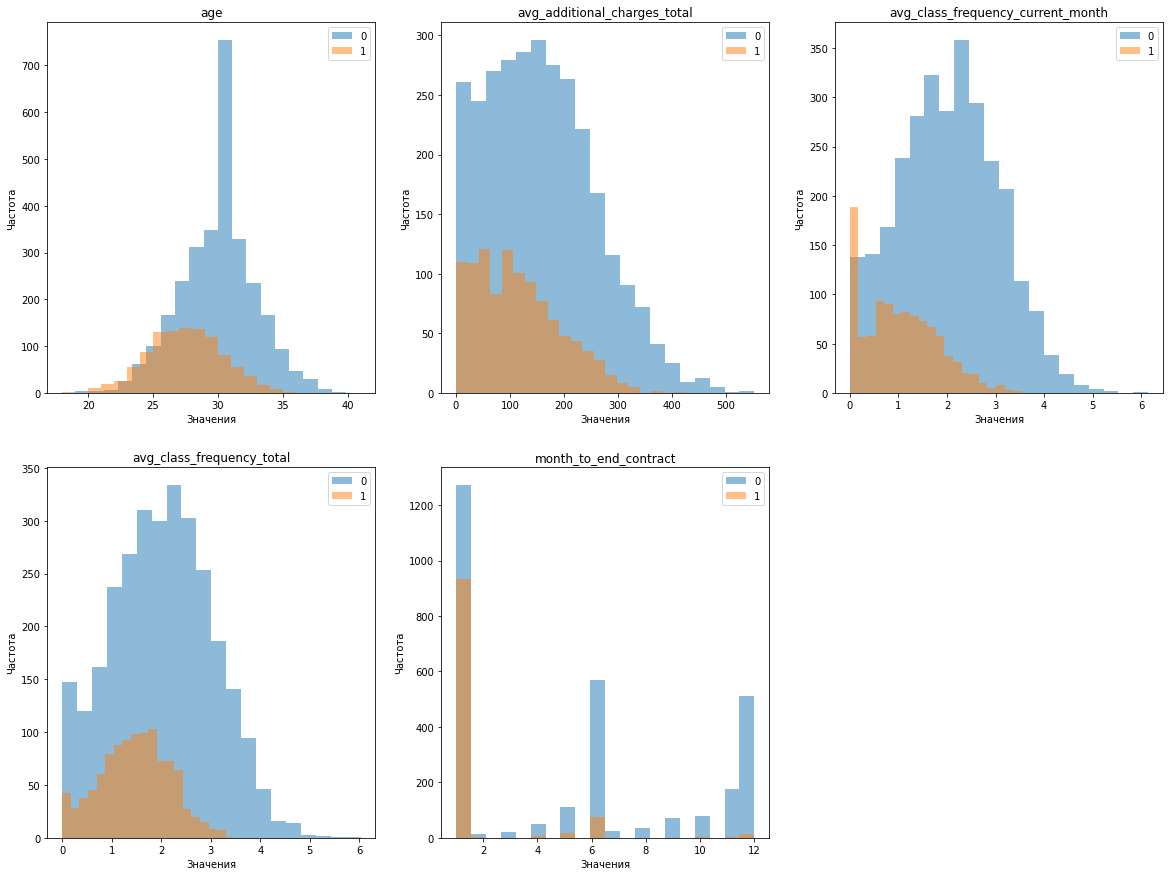

In [9]:
numbers_to_plot = range(1,6)
variables_to_plot = ['age', 'avg_additional_charges_total', 'avg_class_frequency_current_month',
                     'avg_class_frequency_total', 'month_to_end_contract']

plt.figure(figsize=(20, 15))

for i, variable in zip(numbers_to_plot, variables_to_plot):
    df.groupby('churn')[variable].plot(kind='hist', alpha=0.5, bins=20, ax=plt.subplot(2,3,i))
    plt.title(variable)
    plt.xlabel("Значения")
    plt.ylabel('Частота')
    plt.legend()

Выведем столбчатые диаграммы с распределением дискретных признаков среди ушедших в отток клиентов и оставшихся. Можно предварительно сделать следующие выводы насчет ушедших в отток клиентов:
- чаще выбирают абонементы длительностью 1 месяц
- реже ходят на групповые занятия
- являются новыми клиентами (чаще прошло мало времени с момента первого обращения в клуб)
- достаточно часто живут или работают в районе расположения фитнес-клуба
- чуть больше тех, кто не является сотрудником компании-партнера
- большая часть оставляет контактный телефон
- реже пользуются программой "приведи друга"
- примерно равные доли гендерных групп

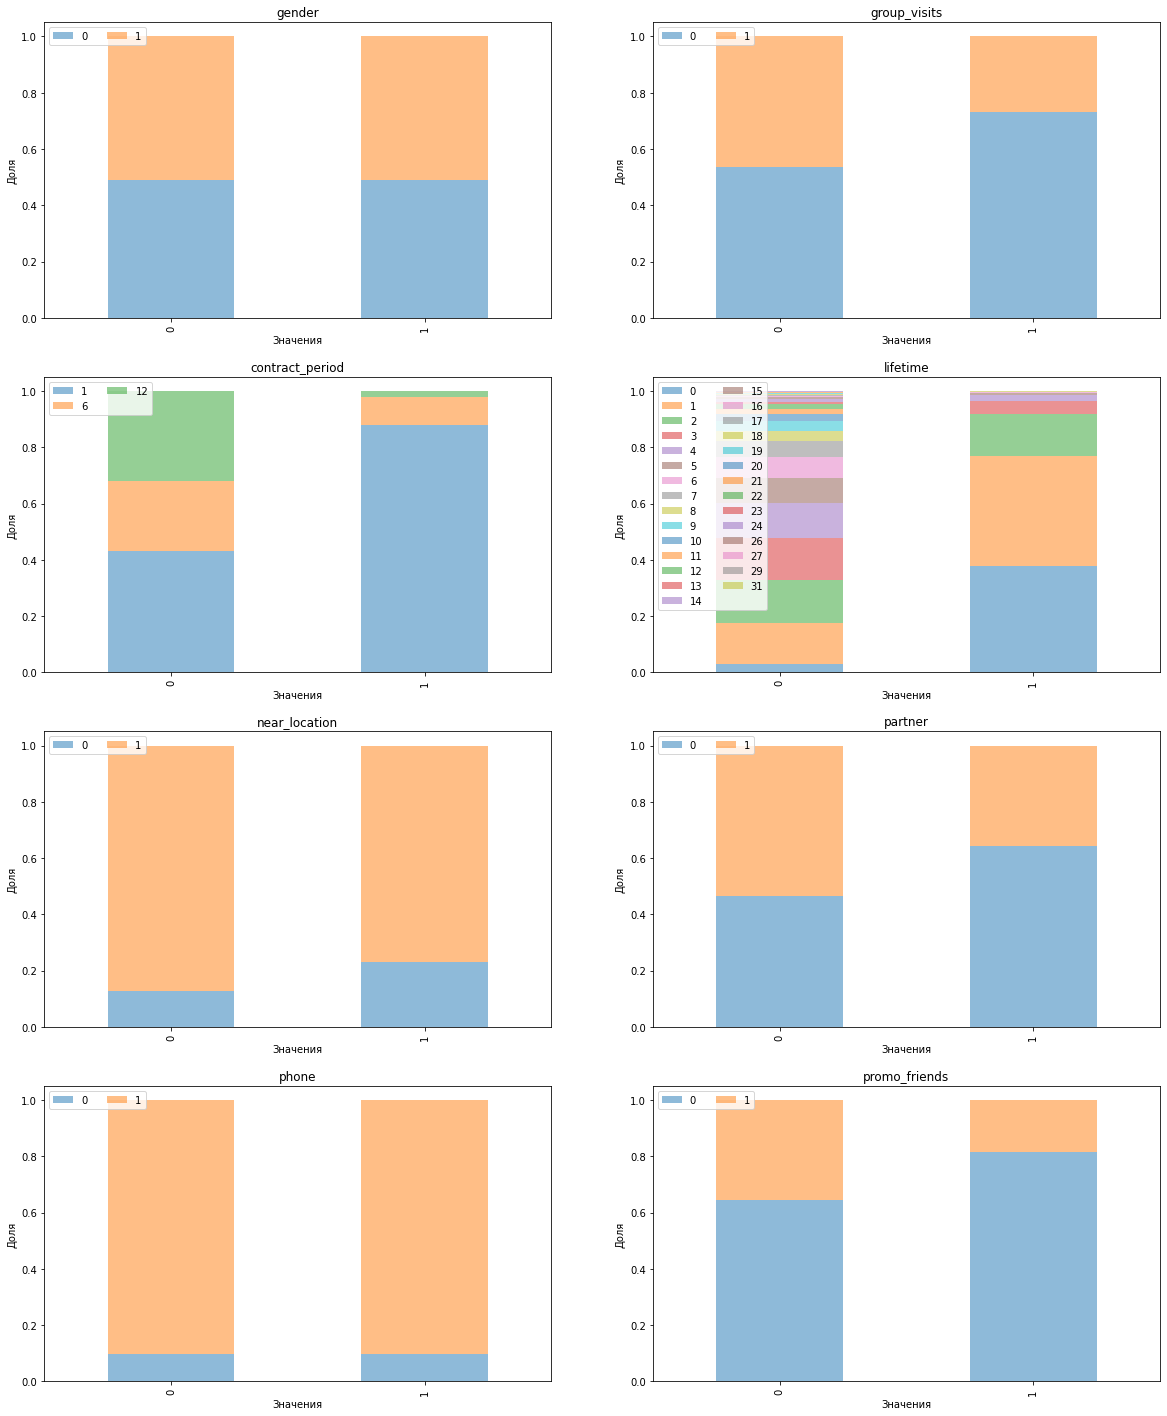

In [10]:
plt.figure(figsize=(20, 25))
def barplot_clusters(variable, churn, place):
    cross_tab_prop = pd.crosstab(index=df[churn],
                                 columns=df[variable],
                                 normalize="index")
    cross_tab_prop.plot(kind='bar',
                        stacked=True,
                        alpha=0.5, ax=plt.subplot(4,2,place))
    plt.legend(loc="upper left", ncol=2)
    plt.title(variable)
    plt.xlabel('Значения')
    plt.ylabel('Доля')

barplot_clusters('gender', 'churn', 1)
barplot_clusters('group_visits', 'churn', 2)
barplot_clusters('contract_period', 'churn', 3)
barplot_clusters('lifetime', 'churn', 4)
barplot_clusters('near_location', 'churn', 5)
barplot_clusters('partner', 'churn', 6)
barplot_clusters('phone', 'churn', 7)
barplot_clusters('promo_friends', 'churn', 8)

### Матрица корреляций

Построим корреляционную матрицу и визуализируем ее. Как мы видим, максимальное значение коэффициента корреляции по модулю - 0.4 (умеренная корреляция), а значит у нас нет необходимости удалять из моделей независимые переменные из-за мультиколлинеарности.

Что касается связей с зависимой переменной `churn`, то наиболее тесные отрицательные связи можно обнаружить с переменными `contact_period` (длительность текущего действующего абонемента), `age` (возраст), `lifetime` (время с момента первого обращения в фитнес-центр в месяцах), `avg_class_frequency_current_month` (средняя частота посещений в неделю за предыдущий месяц).

Вероятно, в регрессионный моделях именно эти переменные будут иметь наибольшие коэффицициенты.

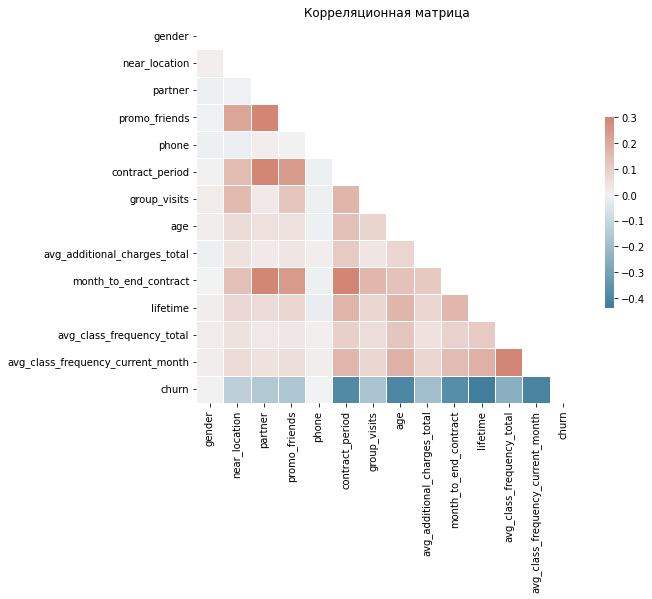

In [11]:
corr = df.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(10, 7))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.title('Корреляционная матрица')
plt.show()

### Вывод по разделу

В этом разделе мы провели исследовательский анализ данных, и можем сделать предварительные выводы:
* Ушедшие в отток клиенты в среднем моложе, меньше посещают занятия, меньше пользуются другими услугами фитнес-клуба, имеют абонементы с меньшей длительностью, реже ходят на групповые занятия, чем оставшиеся клиенты
* Факт оттока клиентов отрицательно связан с длительностью текущего действующего абонемента, возрастом, временем с момента первого обращения в фитнес-центр, средней частотой посещений в неделю за предыдущий месяц.

## Модель прогнозирования оттока клиентов

В этом разделе мы построим модель бинарной классификации с помощью 2 алгоритмов (логистическая регрессия и случайный лес) и сравним их качество.

### Подготовка данных

Сначала отделим независимые переменные от зависимой, затем разделим все данные на обучающую и тестовую выборки в соотношении 80% / 20% и стандартизируем оба набора данных

In [12]:
# выделение независимых и зависимых переменных
X = df.drop(['churn'], axis=1)
y = df['churn']

# разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    random_state=0, stratify=y)

# стандартизация данных
scaler = StandardScaler()
scaler.fit(X_train)

X_train_st = scaler.transform(X_train)
X_test_st = scaler.transform(X_test)

### Обучение моделей и оценка качества

Обучим модель логистической регрессии и предскажем ее результаты на тестовых данных, а также выведем метрики качества модели. Доля правильных ответов (accuracy) равна 0.94, точность (precision) равна 0.9, полнота (recall) равна 0.85.

In [13]:
log_model = LogisticRegression(solver='liblinear')
log_model.fit(X_train_st, y_train)
log_predictions = log_model.predict(X_test_st)
log_probabilities = log_model.predict_proba(X_test_st)[:,1]


def metrics(predictions, probabilities):
    print(' Accuracy:', round(accuracy_score(y_test, predictions), 2), '\n',
          'Precision:', round(precision_score(y_test, predictions), 2), '\n',
          'Recall:', round(recall_score(y_test, predictions), 2), '\n',
         'F1-score:', round(f1_score(y_test, predictions), 2), '\n',
         'ROC-AUC:', round(roc_auc_score(y_test, probabilities), 2))

metrics(log_predictions, log_probabilities)

 Accuracy: 0.94 
 Precision: 0.9 
 Recall: 0.85 
 F1-score: 0.87 
 ROC-AUC: 0.98


Также обучим модель случайного леса и предскажем ее результаты на тестовых данных. В этой модели доля правильных ответов (accuracy) равна 0.92, точность (precision) равна 0.84, полнота (recall) равна 0.81.

In [14]:
forest_model = RandomForestClassifier(random_state=0)
forest_model.fit(X_train_st, y_train)
forest_predictions = forest_model.predict(X_test_st)
forest_probabilities = forest_model.predict_proba(X_test_st)[:,1]

metrics(forest_predictions, forest_probabilities)

 Accuracy: 0.92 
 Precision: 0.88 
 Recall: 0.83 
 F1-score: 0.85 
 ROC-AUC: 0.97


Обе модели работают достаточно хорошо, однако модель логистической регрессии имеет более высокие оценки по precision и recall, так что стоит остановиться на ней. Выведем коэффициенты для каждой независимой переменной.
Оказывается, что наибольшее влияние на факт оттока оказывают средняя частота посещений в неделю за все время с начала действия абонемента, возраст, время с момента первого обращения в фитнес-центр, средняя частота посещений в неделю за предыдущий месяц, причем средняя частота посещений в неделю за все время с начала действия абонемента положительно связана с фактом оттока, а остальные переменные отрицательно. То есть чем старше клиент, чем дольше он ходит в фитнес-клуб и чаще занимается за предыдущий месяц, тем меньше у него шансов уйти в отток в текущем месяце.

Интересно, что средняя частота посещений в неделю за все время с начала действия абонемента наоборот увеличивает шансы уйти в отток.

In [15]:
features = X_test.columns
coef = log_model.coef_[0]
final_coef = pd.DataFrame({'features': features, 'coefficients': coef})
final_coef.sort_values(by='coefficients', ascending=False)

,features,coefficients
11,avg_class_frequency_total,3.105587
0,gender,-0.006316
4,phone,-0.021564
1,near_location,-0.052630
2,partner,-0.068231
3,promo_friends,-0.139599
6,group_visits,-0.393328
8,avg_additional_charges_total,-0.560866
9,month_to_end_contract,-0.617235
5,contract_period,-0.687710


### Вывод по разделу

В этом разделе мы обучили 2 модели и сравнили качество их предсказания. Более точной оказалась модель логистической регрессии, которая показала, что наибольшее влияние на факт оттока оказывают средняя частота посещений в неделю за все время с начала действия абонемента, возраст, время с момента первого обращения в фитнес-центр, средняя частота посещений в неделю за предыдущий месяц.

## Классификация клиентов

В этом разделе мы проведем кластеризацию клиентов фитнес-клуба. Сначала нарисуем дендрограмму для того, чтобы определить число кластеров, а затем проведем кластерный анализ методом k-means.

### Иерархический кластерный анализ

Перед отображением дендрограммы стандартизируем данные, затем строим матрицу расстояний между наблюдениями. Выводим дендрограмму, на которой отображается 4 кластера.

Далее методом k-means мы построим 4-кластерную модель.

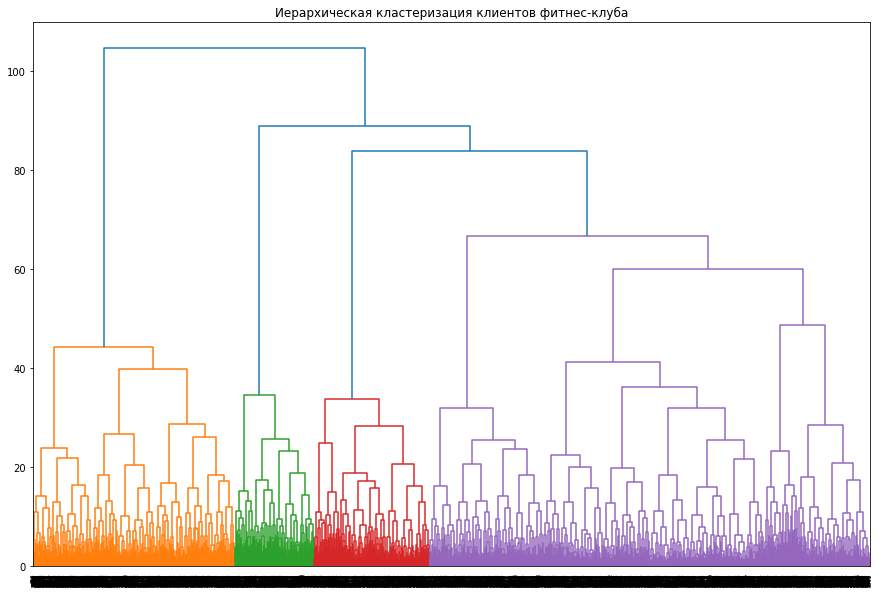

In [16]:
sc = StandardScaler()
X_sc = sc.fit_transform(X)

linked = linkage(X_sc, method = 'ward')

plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.title('Иерархическая кластеризация клиентов фитнес-клуба')
plt.show()

### Кластерный анализ k-means с 4 кластерами

Построим 4-кластерную модель, как подсказала дендрограмма. Как мы видим, доля оттока ниже всего в 3 и 4 кластерах (9% и 3% соответственно), доля оттока выше всего во 2 кластере (56%).

Отличительные черты 2 кластера:
* Ниже доля живущих или работающих в районе расположения фитнес-клуба
* Длительность абонемента короче
* Ниже доля посещения групповых занятий
* Ниже суммарные траты на другие услуги фитнес-центра
* Меньше времени прошло с момента первого обращения в фитнес-центр (в месяцах).
* Меньше раз в неделю посещают фитнес-центр за все время с начала действия абонемента

cluster_4,0,1,2,3
gender,0.523316,0.486815,0.544939,0.503711
near_location,0.862694,0.759297,0.861873,0.940631
partner,0.471503,0.381339,0.343425,0.777365
promo_friends,0.305699,0.190669,0.205298,0.572356
phone,0.000000,1.000000,1.000000,1.000000
contract_period,4.777202,1.899256,2.403027,10.697588
group_visits,0.427461,0.292765,0.447493,0.536178
age,29.297927,28.048005,29.989593,29.912801
avg_additional_charges_total,144.208179,129.704525,157.358764,161.363032
month_to_end_contract,4.466321,1.805274,2.239357,9.768089


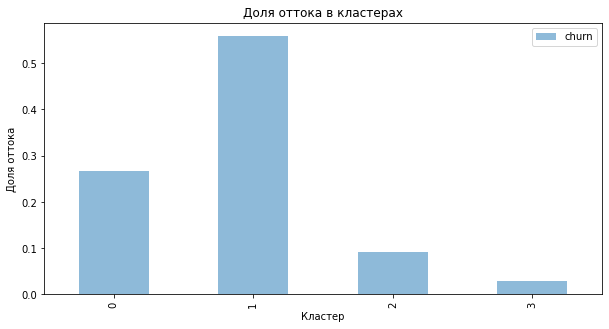

In [18]:
km_4 = KMeans(n_clusters=4, random_state=0)
labels_4 = km_4.fit_predict(X_sc)

df['cluster_4'] = labels_4
display(df.groupby('cluster_4').mean().T)

df.groupby('cluster_4').agg({'churn': 'mean'}).plot(kind='bar', alpha=0.5, figsize=(10, 5))
plt.title('Доля оттока в кластерах')
plt.xlabel('Кластер')
plt.ylabel('Доля оттока')
plt.show()

Выведем распределения признаков для непрерывных величин в разрезе кластеров. Как мы видим клиенты из 2 кластера (индекс 1) реже посещают занятия за последний месяц и с начала приобретения абонемента, им осталось меньше времени до окончания абонемента (возможно, за счет более коротких абонементов).

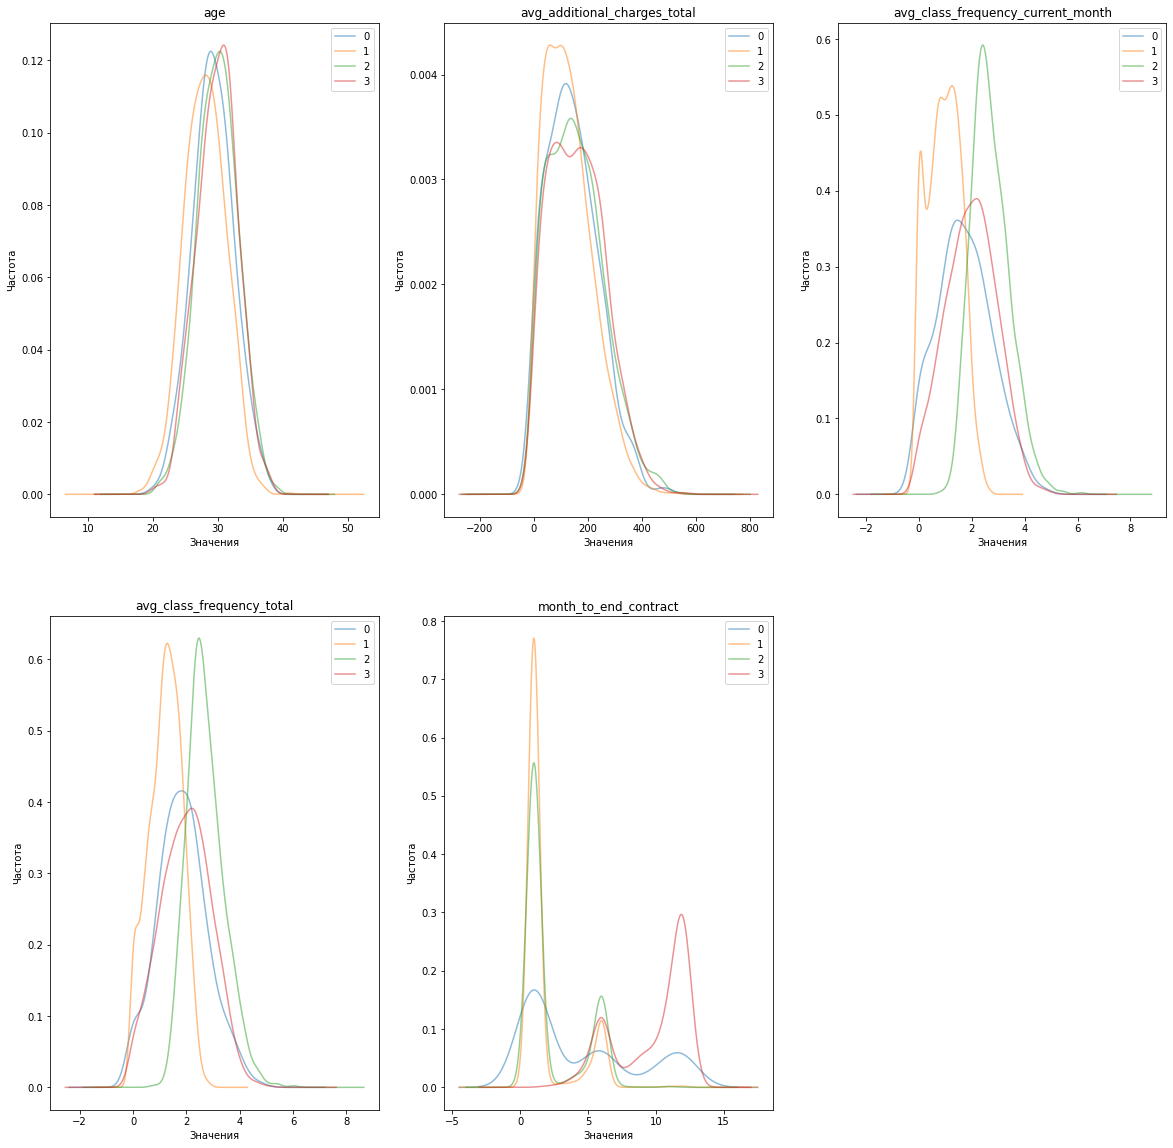

In [19]:
plt.figure(figsize=(20, 20))
for i, variable in zip(numbers_to_plot, variables_to_plot):
    df.groupby('cluster_4')[variable].plot(kind='kde', alpha=0.5, ax=plt.subplot(2,3,i))
    plt.title(variable)
    plt.xlabel("Значения")
    plt.ylabel('Частота')
    plt.legend()

Выведем столбчатые диаграммы с нормированием для дискретных признаков в разрезе кластеров. Как мы видим, клиенты из 2 кластера (индекс 1) меньше посещают групповые занятия, имеют более короткие абонементы, доля новых клиентов выше, доля не живущих / работающих клиентов в районе фитнес-клуба выше.

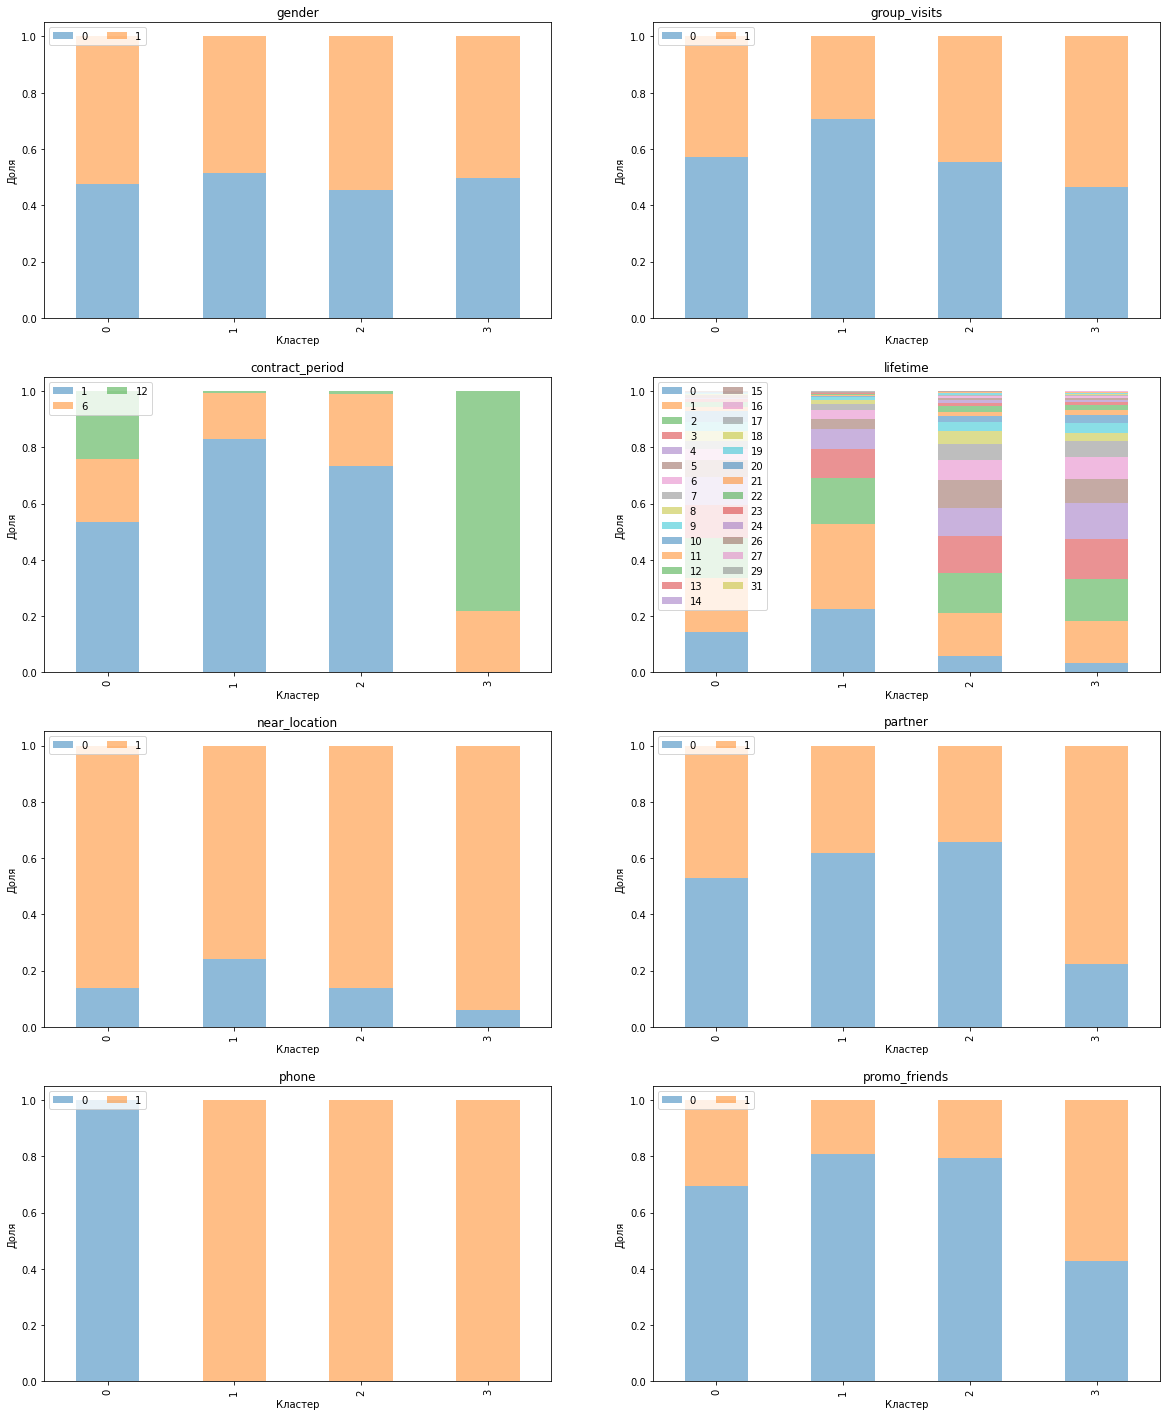

In [20]:
def barplot_clusters(variable, cluster, place):
    cross_tab_prop = pd.crosstab(index=df[cluster],
                                 columns=df[variable],
                                 normalize="index")
    cross_tab_prop.plot(kind='bar',
                        stacked=True,
                        alpha=0.5, ax=plt.subplot(4,2,place))
    plt.legend(loc="upper left", ncol=2)
    plt.title(variable)
    plt.xlabel('Кластер')
    plt.ylabel('Доля')


plt.figure(figsize=(20, 25))
barplot_clusters('gender', 'cluster_4', 1)
barplot_clusters('group_visits', 'cluster_4', 2)
barplot_clusters('contract_period', 'cluster_4', 3)
barplot_clusters('lifetime', 'cluster_4', 4)
barplot_clusters('near_location', 'cluster_4', 5)
barplot_clusters('partner', 'cluster_4', 6)
barplot_clusters('phone', 'cluster_4', 7)
barplot_clusters('promo_friends', 'cluster_4', 8)

### Вывод по разделу

В этом разделе мы провели иерархический кластерный анализ, а затем 2 анализа методом k-means (на 4 и 5 кластеров). 4-кластерная модель легче интерпретируется, так что стоит остановиться на ней.
Модель показывает, что в кластерах с высокой долей оттока клиенты реже посещают занятия за последний месяц и с начала приобретения абонемента, им осталось меньше времени до окончания абонемента, меньше посещают групповые занятия, имеют более короткие абонементы, доля новых клиентов выше, доля не живущих / работающих клиентов в районе фитнес-клуба выше.

## Основные выводы и базовые рекомендации по работе с клиентами

В заключение стоит еще раз остановиться на основных выводах и рекомендациях для стратегии взаимодействия с клиентами.

Основные выводы:
* Модель логистической регрессии показала, что наибольшее влияние на факт оттока оказывают средняя частота посещений в неделю за все время с начала действия абонемента, возраст, время с момента первого обращения в фитнес-центр, средняя частота посещений в неделю за предыдущий месяц
* Ушедшие в отток клиенты в среднем моложе, меньше посещают занятия за последний месяц и за все время действия абонемента, меньше пользуются другими услугами фитнес-клуба, имеют абонементы с меньшей длительностью, реже ходят на групповые занятия, 
* Факт оттока клиентов отрицательно связан с длительностью текущего действующего абонемента, возрастом, временем с момента первого обращения в фитнес-центр, средней частотой посещений в неделю за предыдущий месяц.
* Кластерный анализ показал, что клиенты в кластерах с наименьшим оттоком чаще посещают групповые занятия, имеют более длительные абонементы, большая доля живет / работает в районе расположения фитнес-центра, большая доля пользуется программой "приведи друга".


Таким образом, основные рекомендации для стратегии будут касаться вовлечения клиентов во все разнообразие услуг фитнес-центра: групповые занятия, другие услуги центра (массаж, кафе и т. д.).

Также, так как мы выявили, что доля оттока ниже среди старых клиентов, стоит работать над увеличением продолжительности пользования центром. Возможно, стоит поднять минимальную длительность абонемента до 6 месяцев, либо придумать программы лояльности для клиентов, остающихся долго членами клуба.